# Explore gradient descent autocorelation

## Test sgd on toy dataset

In [3]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array([1, 1, 2, 2])
# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(loss='squared_error',max_iter=1000, tol=1e-3, verbose=0, learning_rate='optimal', eta0=0.1))
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(eta0=0.1, loss='squared_error'))])

In [4]:
clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :]

array([[ 6.33088621e-01,  1.00100100e+00],
       [-3.35872506e+01, -2.60520521e+01],
       [ 1.01368756e+02,  1.87359157e+02],
       [-6.91203767e+03, -5.35711845e+03],
       [ 8.79709027e+04,  1.44671538e+05],
       [-4.96484093e+06, -3.84985213e+06],
       [ 1.48116494e+07,  2.74235051e+07],
       [-1.00834643e+09, -7.81438361e+08],
       [ 1.27767696e+10,  2.10155511e+10],
       [-7.18265269e+11, -5.56913098e+11],
       [-7.95576208e+10,  4.53545968e+11],
       [-1.35974158e+12, -5.58016989e+11],
       [-7.20400845e+11,  4.54444078e+11],
       [-2.00375025e+12, -5.59120880e+11],
       [-1.36377642e+12,  4.55342189e+11],
       [-7.99514704e+10,  1.47180726e+12],
       [-7.23248279e+11,  4.56240300e+11],
       [-6.58680412e+11,  5.08297510e+11],
       [-1.48438660e+10,  1.52781633e+12],
       [-1.30509306e+12,  5.09297112e+11],
       [-6.60623422e+11,  1.53081793e+12],
       [-1.95403806e+12,  5.10296714e+11],
       [-1.30893533e+12,  1.53381954e+12],
       [-2.

In [5]:
clf['sgdclassifier'].coef_

array([[-2.48718372e+13,  4.88075361e+12]])

In [6]:
gradients_seq = clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :] \
                - clf['sgdclassifier'].weights_sequence[1:clf['sgdclassifier'].n_iter_*len(X)+1, :]
gradients_seq = gradients_seq[:-1]

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [8]:
sm.tsa.stattools.acf(gradients_seq[:, 0])

array([ 1.        , -0.61814333,  0.37159869, -0.10340514, -0.04846458,
        0.0265276 , -0.09576415, -0.09820704,  0.20734816, -0.36624684,
        0.36304335, -0.23231116,  0.21411856, -0.09685406])

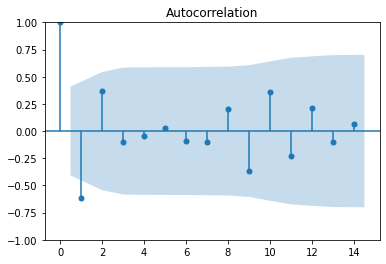

In [9]:
sm.graphics.tsa.plot_acf(gradients_seq[:, 0])
plt.show()

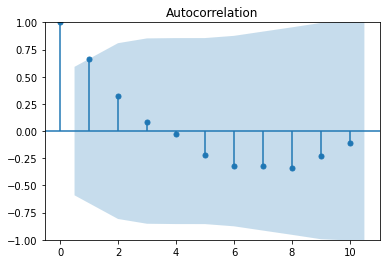

In [10]:
sm.graphics.tsa.plot_acf(gradients_seq[gradients_seq[:, 1] > 0][:, :1])
plt.show()

## Test on breast cancer dataset

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score

data = load_breast_cancer()
y = data.target
X = data.data

clf = make_pipeline(StandardScaler(),
                    SGDClassifier(loss='log',max_iter=1000, tol=1e-3, verbose=0, learning_rate='constant', eta0=0.001))
clf.fit(X, y)
auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])
print(auc)

0.9958511706569421


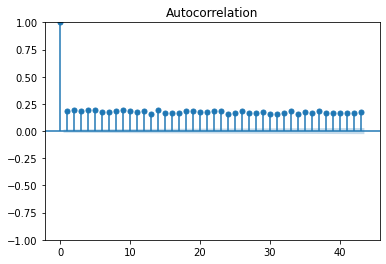

In [12]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

gradients_seq = clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :] \
                - clf['sgdclassifier'].weights_sequence[1:clf['sgdclassifier'].n_iter_*len(X)+1, :]
gradients_seq = gradients_seq[:-1]
sm.graphics.tsa.plot_acf(gradients_seq[:, 0])
plt.show()

In [13]:
ind_large_coef = np.argsort(abs(clf['sgdclassifier'].coef_[0]))[-5:]

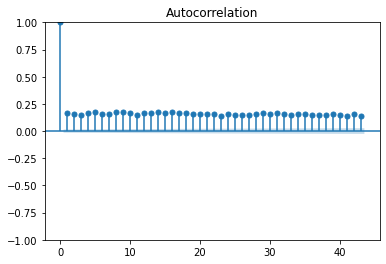

In [14]:
for coef in ind_large_coef:
    sm.graphics.tsa.plot_acf(gradients_seq[:, coef]) # [gradients_seq[:, coef] > 0]
    plt.show()

In [15]:
y = gradients_seq[:, ind_large_coef[-1]]
x = np.arange(len(y))

plt.plot(x, y)
plt.show()

### Cosine similarities

In [122]:
from scipy import spatial

dataSetI = [3, 45, 7, 2]
dataSetII = [2, 54, 13, 15]
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)

In [126]:
gradients_0 = gradients_seq[:-1]
gradients_1 = gradients_seq[1:]
gradients_seq_pairs = list(zip(gradients_seq[:-1], gradients_seq[1:]))

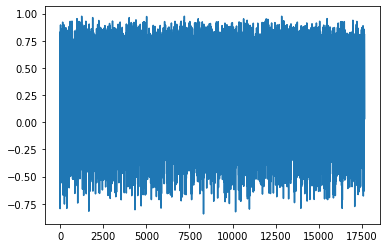

In [132]:
y = list(map(lambda x: 1 - spatial.distance.cosine(x[0], x[1]), gradients_seq_pairs))
x = np.arange(len(y))

plt.plot(x, y)
plt.show()

## Explore multiple loss and learning rates

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt


data = load_breast_cancer()
y = data.target
X = data.data
n_samples = len(X)
index_test = random.sample(range(n_samples), int(0.2 * n_samples))
index_train = [i for i in range(n_samples) if i not in index_test]
X_test = X[index_test, :]
y_test = y[index_test]
X = X[index_train, :]
y = y[index_train]

losses = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
learning_rates = {'constant': [0.1, 0.01, 0.001], 'optimal': [0.1], 'invscaling': [0.1, 0.01, 0.001], 'adaptive': [0.1, 0.01, 0.001]}

max_iter = 1000
tol = 1e-4
early_stopping = True
results = []

for loss in losses:
    for learning_rate in learning_rates.keys():
        for eta0 in learning_rates[learning_rate]:
            clf = make_pipeline(StandardScaler(),
                                SGDClassifier(loss=loss, max_iter=max_iter, tol=tol, verbose=0, learning_rate=learning_rate, eta0=eta0))
            clf.fit(X, y)
            auc = roc_auc_score(y_test, clf.decision_function(X_test))
            
            gradients_seq = clf['sgdclassifier'].weights_sequence[:clf['sgdclassifier'].n_iter_*len(X), :] \
                            - clf['sgdclassifier'].weights_sequence[1:clf['sgdclassifier'].n_iter_*len(X)+1, :]
            gradients_seq = gradients_seq[:-1]
            # compute acf for lag=1 on all features of the gradient
            acfs = [sm.tsa.stattools.acf(gradients_seq[:, i])[1] for i in range(gradients_seq.shape[1])]
            acf_max = np.max(acfs)
            acf_min = np.min(acfs)
            acf_mean = np.mean(acfs)
            acf_std = np.std(acfs)
            
            results.append({'loss': loss, 'learning_rate': learning_rate, 'eta0': eta0, 
                            'auc': auc, 'acf_max': acf_max, 'acf_min': acf_min,
                            'acf_mean': acf_mean, 'acf_std': acf_std})
            
df_results = pd.DataFrame.from_records(results)

In [2]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

df_plot = df_results.set_index(['loss', 'learning_rate', 'eta0']).acf_max.unstack(level=0)
plt.figure(figsize=(7, 7))
ax = sns.heatmap(df_plot, cmap="YlGnBu")
plt.show()

* measure on biggest coef (log reg)
* measure after lasso
* measure with "rolling acf" from start to end of training
* tune number of samples in sgd

* acf for near optimal lr
* check how much acf is needed to get reasonnable improvement in dp
* transfer to py

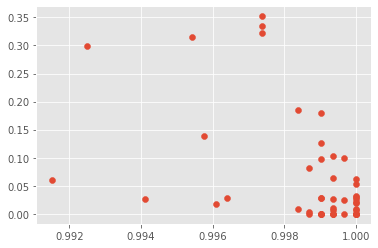

In [3]:
df_plot = df_results.loc[df_results.auc >= df_results.auc.max()*(1-0.1)]
plt.scatter(df_plot.auc, df_plot.acf_max)
plt.show()

## Plain gradient descent

In [129]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import copy

data = load_breast_cancer()
y = data.target
X = data.data
n_samples = len(X)
index_test = random.sample(range(n_samples), int(0.1 * n_samples))
index_train = [i for i in range(n_samples) if i not in index_test]
X_test = X[index_test, :]
y_test = y[index_test]
X = X[index_train, :]
y = y[index_train]

scaler = StandardScaler()
clf = SGDClassifier(loss='hinge', learning_rate='optimal', eta0=0.01, warm_start=True, penalty='l1')
X = scaler.fit_transform(X)

coefs = []
etas = []
n_epochs = 100
for _ in range(n_epochs):
    clf.partial_fit(X, y, classes=np.unique(y))
    coefs.append(copy.copy(clf.coef_))
    etas.append(copy.copy(clf.eta))

auc = roc_auc_score(y_test, clf.decision_function(scaler.transform(X_test)))
print(auc)

0.9947916666666667


In [130]:
coefs = np.array(list(map(lambda x: x.ravel(), np.array(coefs))))
dif_coef = coefs[:-1] - coefs[1:]
grad_seq = -np.array([dif_coef[i] / etas[i] for i in range(len(dif_coef))])

In [131]:
acfs = [sm.tsa.stattools.acf(grad_seq[:, i])[1] for i in range(grad_seq.shape[1])]
acf_max = np.max(acfs)
acf_min = np.min(acfs)
acf_mean = np.mean(acfs)
acf_std = np.std(acfs)

In [132]:
print(acf_max, acf_min, acf_mean, acf_std)

-0.15580922431518288 -0.5148082573882952 -0.3608698938836168 0.09089423033971304


In [135]:
sm.graphics.tsa.plot_acf(grad_seq[:, 10]) # [gradients_seq[:, coef] > 0]
plt.show()

## Toy dataset 1dimension

In [244]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

n_samples = 1000
x = np.linspace(1, 1000, n_samples)
y = (10 + np.random.randn(n_samples)) *x + 5*np.random.randn(n_samples)
X = x.reshape(-1, 1)
y = y.reshape(-1, 1)

m, b = 0.2, 0 # parameters, no intercept
log, mse, grad_seq = [], [], [] # lists to store learning process
N = len(X) # number of samples
lr=0.0001

for _ in range(10):

    f = y - m*X

    # Updating m
    grad = (-2 * X.T.dot(f) / N)[0][0]
    m = m - lr * grad

    grad_seq.append(grad)
    log.append((m, b))
    mse.append(((y - (m*X + b))**2).mean())     

In [255]:
mse

[323918.7980710294,
 282189.8855626107,
 245894.34137044923,
 214324.70657732166,
 186865.63789123527,
 162981.91360845216,
 142208.00127598335,
 124138.98371040224,
 108422.666506397,
 94752.71319762297,
 82862.6742630283,
 72520.79359431838,
 63525.49119420209,
 55701.4340558952,
 48896.11863896161,
 42976.89832841363,
 37828.39793743673,
 33350.264858211085,
 29455.21302711859,
 26067.321578050618,
 23120.55502181494,
 20557.47610754278,
 18328.126277680945,
 16389.051894824377,
 14702.457259973524,
 13235.46791317132,
 11959.489857056222,
 10849.652213561187,
 9884.322450235304,
 9044.684727164162,
 8314.37314578791,
 7679.152751042616,
 7126.642069040336,
 6646.071772097919,
 6228.074767105401,
 5864.503615716388,
 5548.271727584325,
 5273.215231243753,
 5033.9728302764115,
 4825.881302964332,
 4644.884608549003,
 4487.454828430455,
 4350.523401322157,
 4231.421312023703,
 4127.827067993534,
 4037.7214497008904,
 3959.34815276815,
 3891.179554755115,
 3831.8869393244904,
 3780.314

MSE: 3023.4795560737753


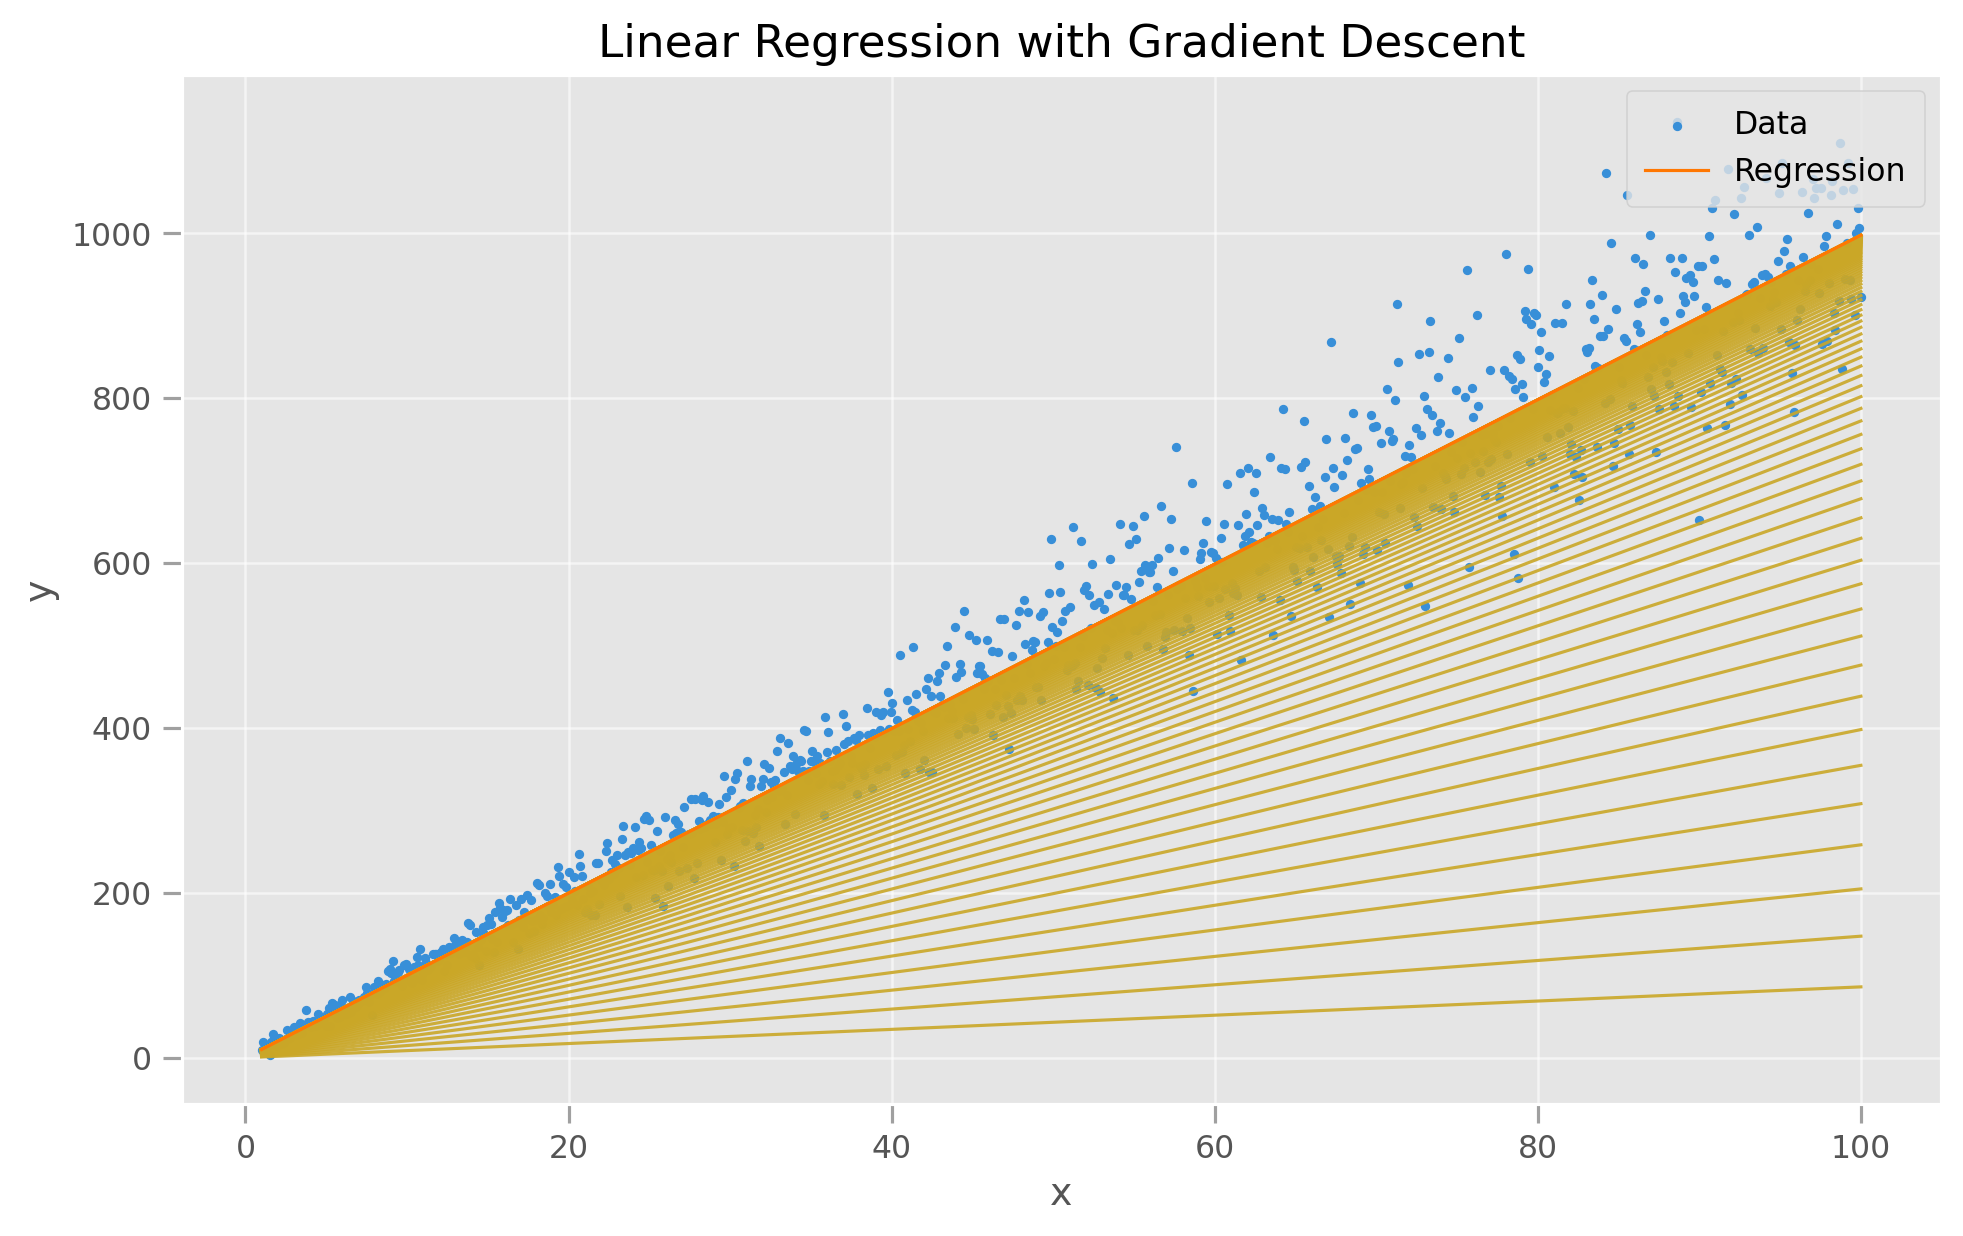

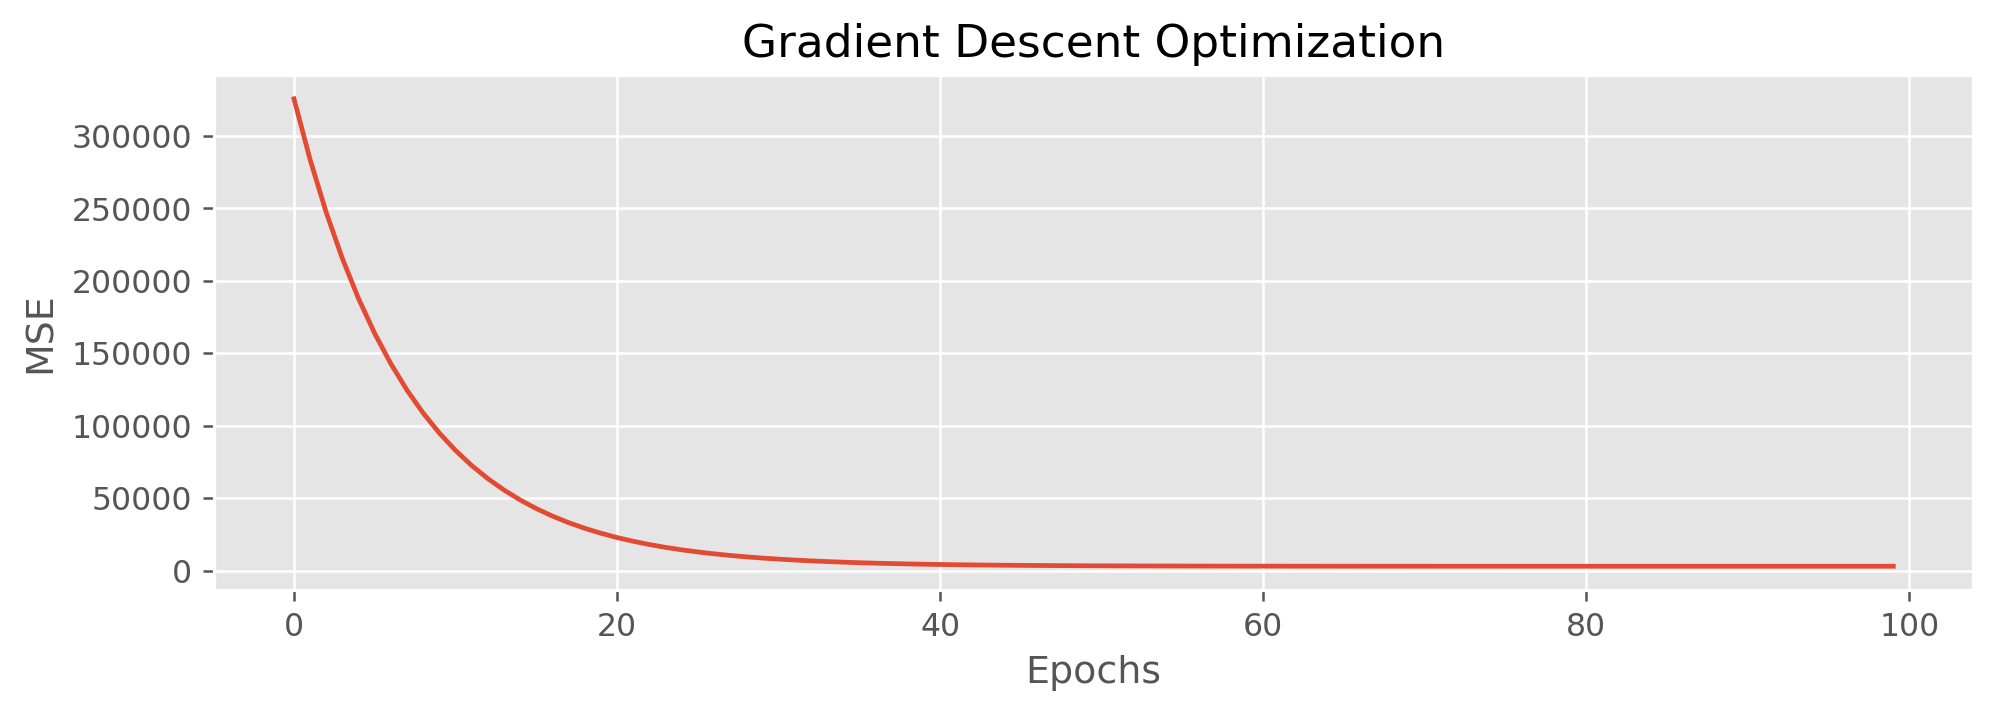

In [258]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

n_samples = 1000
x = np.linspace(1, 100, n_samples)
y = (10 + np.random.randn(n_samples)) *x + 5*np.random.randn(n_samples)
X = x.reshape(-1, 1)
y = y.reshape(-1, 1)

def gradient_descent(X, y, lr=0.05, epoch=10):    
    '''
    Gradient Descent for a single feature
    '''    
    m, b = 0.2, 0 # parameters, no intercept
    log, mse, grad_seq = [], [], [] # lists to store learning process
    N = len(X) # number of samples
    
    for _ in range(epoch):
                
        f = y - m*X
    
        # Updating m
        grad = (-2 * X.T.dot(f) / N)[0][0]
        m = m - lr * grad
        
        grad_seq.append(grad)
        log.append((m, b))
        mse.append(((f)**2).mean())        
    
    return m, b, log, mse, grad_seq

m, b, log, mse, grad_seq = gradient_descent(X, y, lr=0.00001, epoch=100)

y_pred = m*X + b


def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(10,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.9)
    plt.plot(X, y_pred, c='#ff7702', lw=1, label='Regression')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

print("MSE:", ((y - (y_pred))**2).mean())
plot_regression(X, y, y_pred, log=log, title="Linear Regression with Gradient Descent")

plt.figure(figsize=(10,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('Gradient Descent Optimization')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

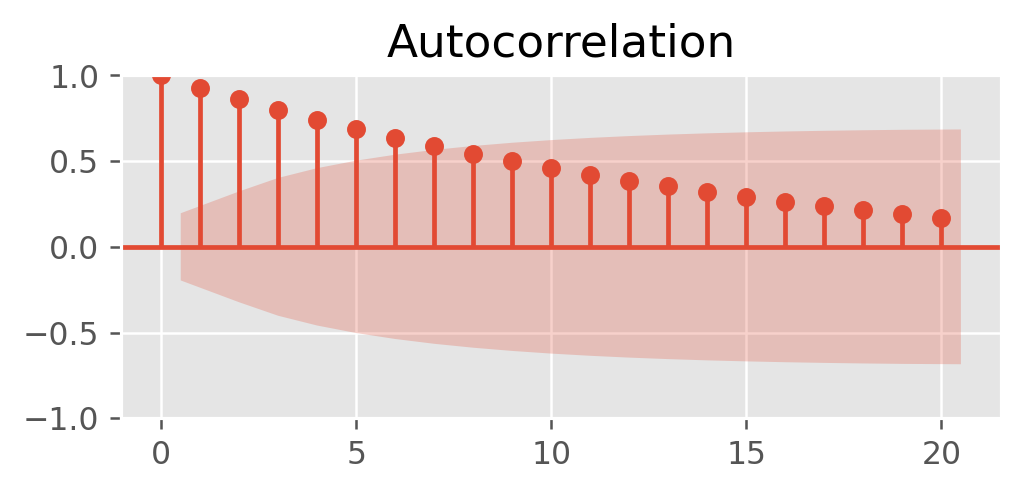

In [259]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(5, 2))
sm.graphics.tsa.plot_acf(np.array(grad_seq), ax=ax)
plt.show()

Try with Raphson-Newton method - use the Hessian to calibrate the learning rate

MSE: 3343.7086998364234


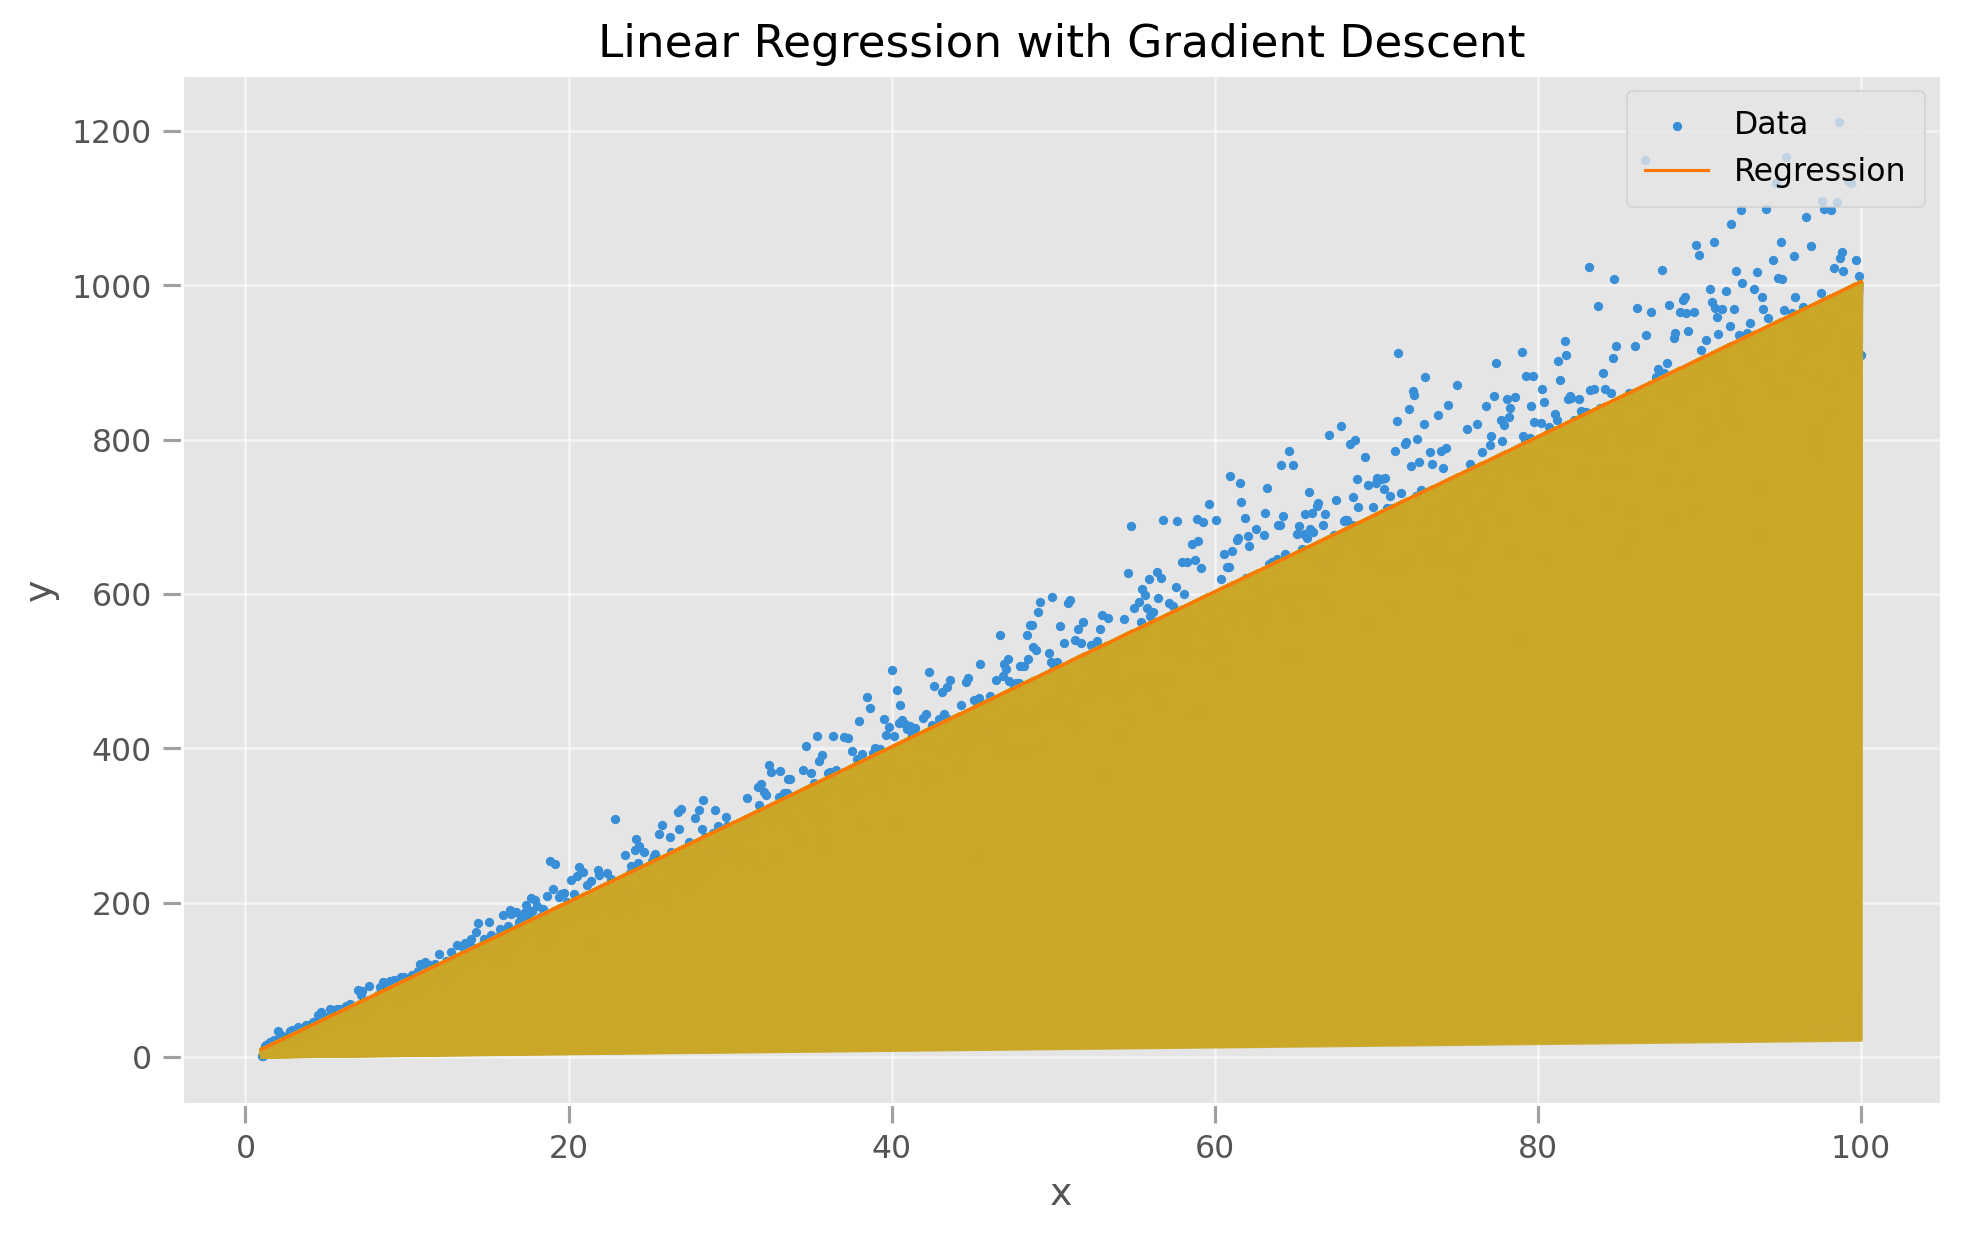

In [7]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

n_samples = 1000
x = np.linspace(1, 100, n_samples)
y = (10 + np.random.randn(n_samples)) *x + 5*np.random.randn(n_samples)
X = x.reshape(-1, 1)
y = y.reshape(-1, 1)

def get_loss(X, y, m):
    return y - m*X

def get_gradient(X, y, m):
    N = len(X)
    return (-2 * X.T.dot(get_loss(X, y, m)) / N)[0][0]

def get_hessian(X):
    return X.T.dot(X)[0][0]

def gradient_descent(X, y, epoch=10):    
    '''
    Gradient Descent for a single feature
    '''    
    m, b = 0.2, 0 # parameters, no intercept
    log, mse, grad_seq = [], [], [] # lists to store learning process
    N = len(X) # number of samples
    hessian = get_hessian(X)
    
    for _ in range(epoch):
                
        f = y - m*X
    
        # Updating m
        grad = (-2 * X.T.dot(f) / N)[0][0]
        m = m -  grad / hessian
        
        grad_seq.append(grad)
        log.append((m, b))
        mse.append(((f)**2).mean())        
    
    return m, b, log, mse, grad_seq

m, b, log, mse, grad_seq = gradient_descent(X, y, epoch=10000)

y_pred = m*X + b


def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(10,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.9)
    plt.plot(X, y_pred, c='#ff7702', lw=1, label='Regression')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

print("MSE:", ((y - (y_pred))**2).mean())
plot_regression(X, y, y_pred, log=log, title="Linear Regression with Gradient Descent")

plt.figure(figsize=(10,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse)), mse)
plt.title('Gradient Descent Optimization')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

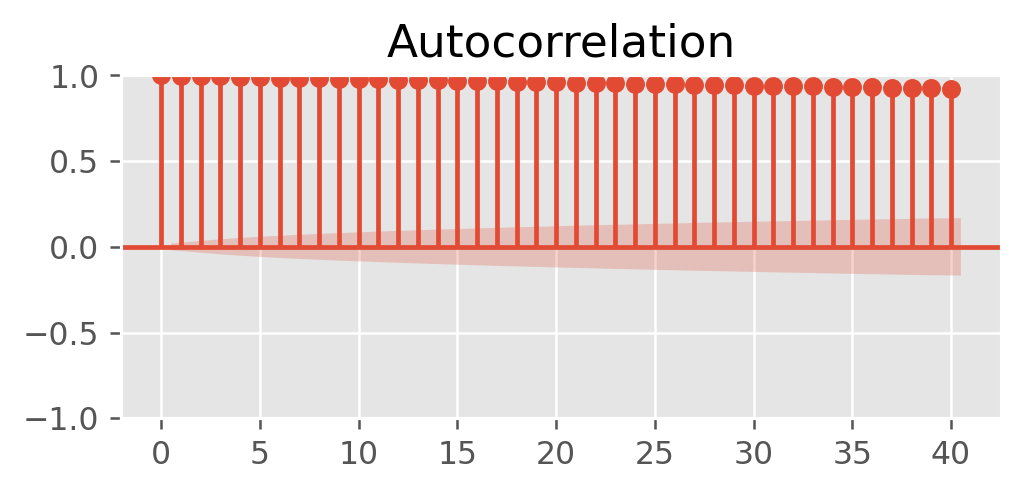

In [8]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(5, 2))
sm.graphics.tsa.plot_acf(np.array(grad_seq), ax=ax)
plt.show()

## Toy dataset ndimension

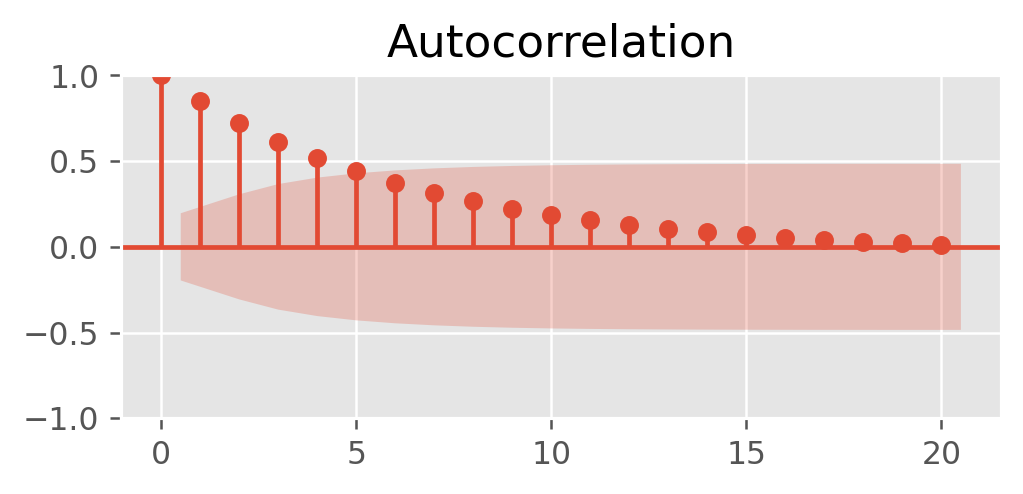

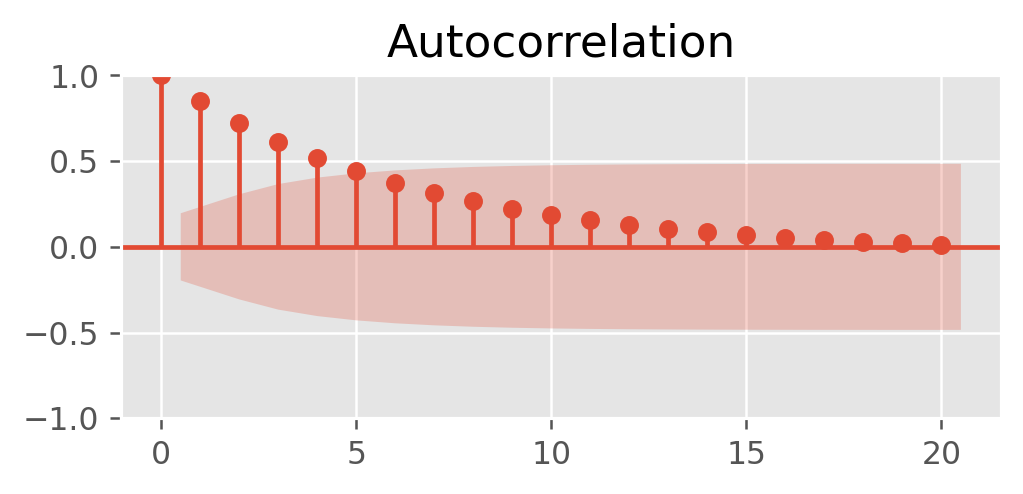

In [9]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

n_samples = 1000
x1 = np.linspace(1, 10, n_samples)
x2 = np.linspace(1, 10, n_samples)
y = (10 + np.random.randn(n_samples)) *x1 + 345*x2 + 5*np.random.randn(n_samples)
X = np.stack((x1, x2), axis=1)
y = y.reshape(-1, 1)

def get_hessian(X):
    return X.T.dot(X)[0][0]

def gradient_descent(X, y, lr=0.05, epoch=10):
    m, b = np.array([0.2, 0.1]).reshape(2, 1), 0 # parameters, no intercept
    log, mse = [], [] # lists to store during the learning process
    N = len(X) # number of samples
    grad_seq = np.empty((1, 2))
    
    for _ in range(epoch):
                
        f = y - X.dot(m)
    
        # Updating m
        grad = -2 * X.T.dot(f) / N
        m = m - lr * grad
        
        grad_seq = np.concatenate([grad_seq, grad.reshape(1, 2)])
        log.append((m, b))
        mse.append((f**2).mean())        
    
    return m, b, log, mse, grad_seq[1:,:]

m, b, log, mse, grad_seq = gradient_descent(X, y, lr=0.001, epoch=100)

for i in range(grad_seq.shape[1]):
    fig, ax = plt.subplots(figsize=(5, 2))
    sm.graphics.tsa.plot_acf(np.array(grad_seq[:, i]), ax=ax)
    plt.show()

## Classification

We are going to build a plain Newton like descent for logistic regressions. We will try this algo on a toy dataset and then on MNIST.

In [224]:
import numpy as np

def get_sigmoid(X, m):
    return 1. / (1. + np.exp(-X.dot(m)))

def get_loss(X, y, m):
    probs = get_sigmoid(X, m)
    return - np.sum(y * np.log(probs)
                  + (1 - y) * np.log(1 - probs))

def get_gradient(X, y, m):
    return X.T.dot(((get_sigmoid(X, m) - y)))

def get_inv_hessian(X, y, m):
    probs = get_sigmoid(X, m)
    W = np.diag((probs * (1 - probs)).flatten())
    hessian = X.T.dot(W).dot(X)
    return np.linalg.inv(hessian)

def get_clip(v, c):
    v_norm = np.linalg.norm(v)
    return v / np.max([1, v_norm / c])

def gradient_descent(X, y, intercept=False, newton=False, lr=0.001, c=None, epochs=10):
    if intercept:
        X = np.concatenate([X, np.ones((len(X), 1))], axis=1)
    ndim = X.shape[1]
    m = np.random.normal(0, 0.01, ndim).reshape((ndim, 1))
    loss_seq = []
    grad_seq = []
    
    for _ in range(epochs):
        
        grad = get_gradient(X, y, m)
        if c is not None:
            grad = get_clip(grad, c)
        if newton:
            inv_hess = get_inv_hessian(X, y, m)
            step = inv_hess.dot(grad)
        else:
            step = lr * grad
        m = m - step
        
        loss = get_loss(X, y, m)
        
        grad_seq.append(grad.flatten())
        loss_seq.append(loss)       
    
    return m, np.array(loss_seq), np.array(grad_seq)

toy dataset

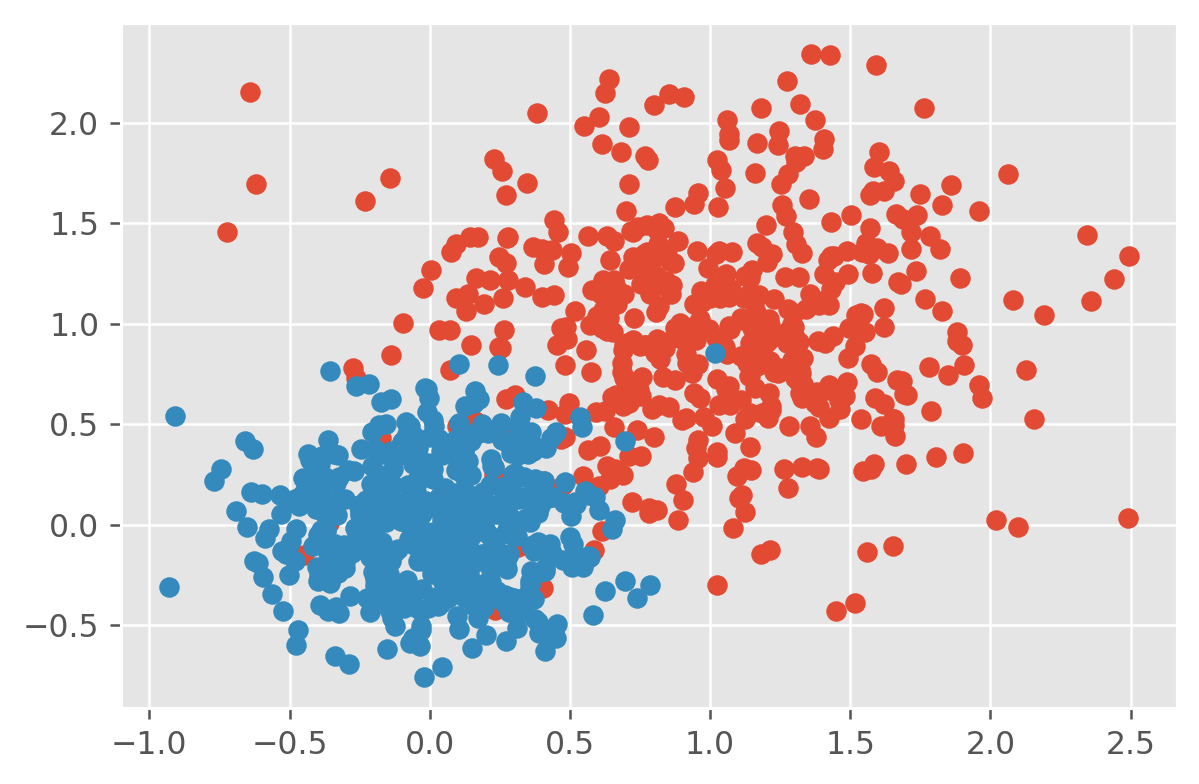

In [225]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

x1 = np.random.normal([1, 1],0.5,(500, 2))
x2 = np.random.normal([0, 0],0.3,(500, 2))
y = np.array([1] * 500 + [0] * 500)
X = np.concatenate((x1, x2))
y = y.reshape(-1, 1)

plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.show()

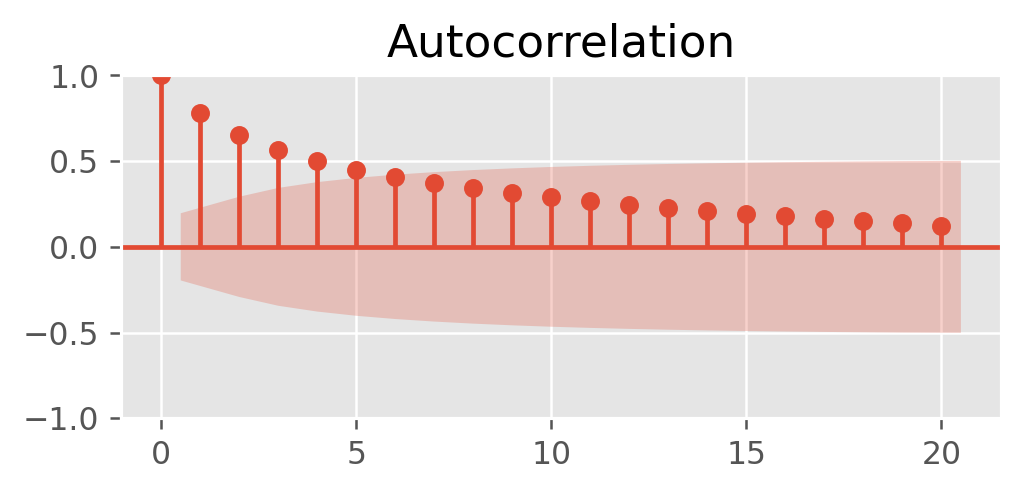

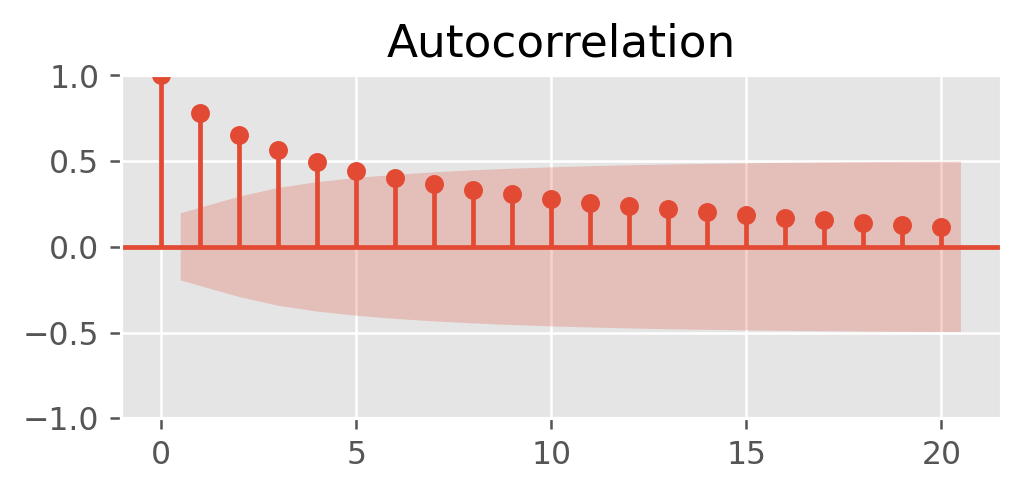

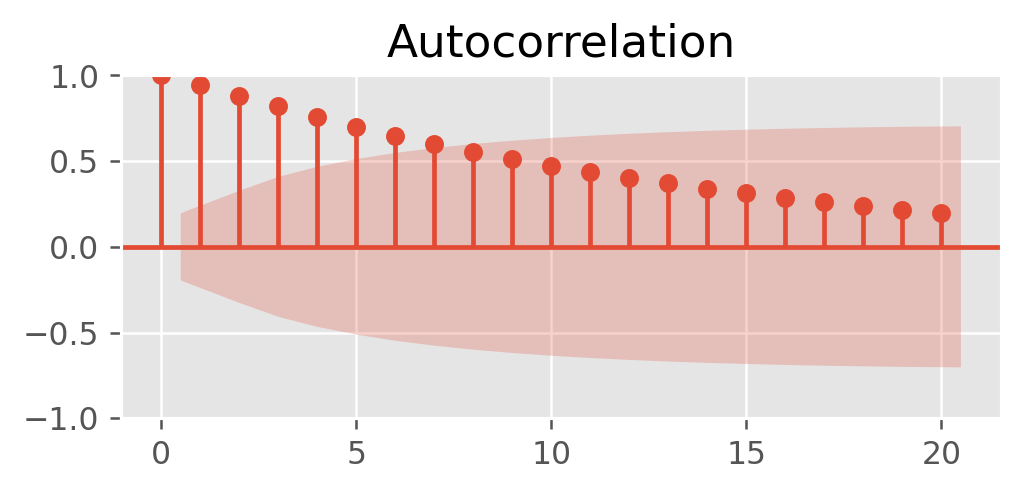

In [199]:
m, loss_seq, grad_seq = gradient_descent(X, y, newton=False, intercept=True, epochs=100)

for i in range(grad_seq.shape[1]):
    fig, ax = plt.subplots(figsize=(5, 2))
    sm.graphics.tsa.plot_acf(np.array(grad_seq[:, i]), ax=ax)
    plt.show()

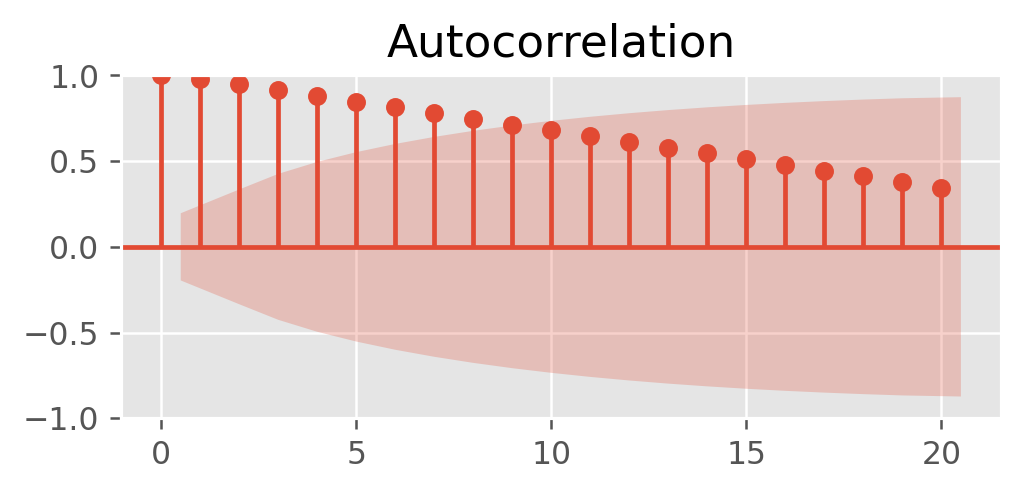

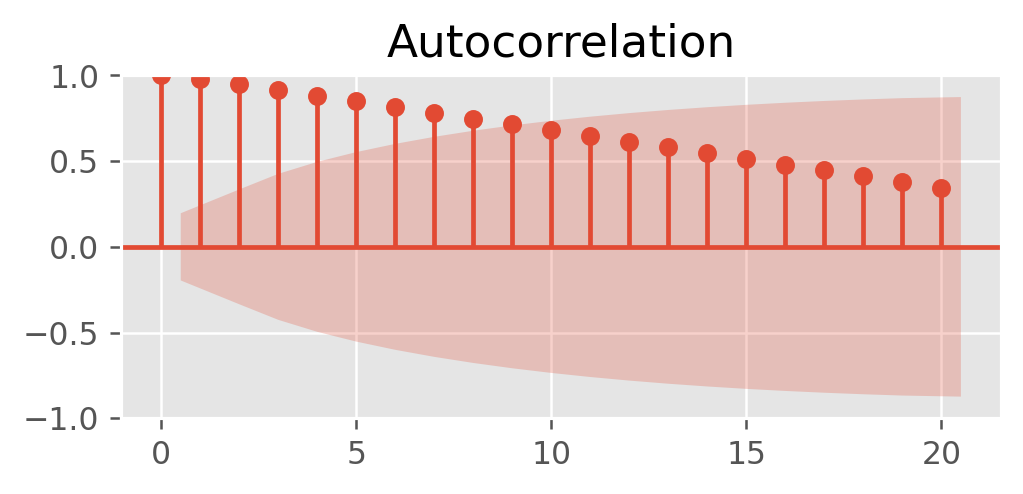

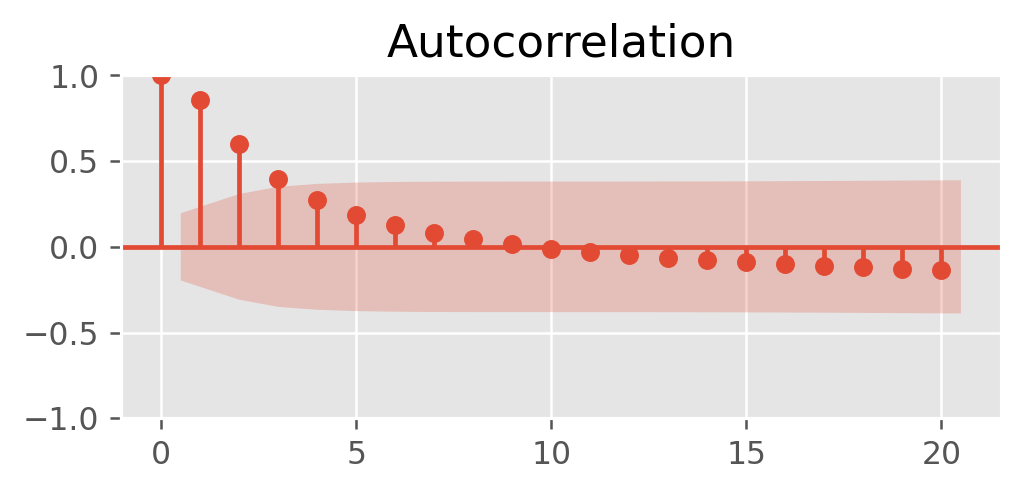

In [231]:
m, loss_seq, grad_seq = gradient_descent(X, y, newton=True, intercept=True, c=10, epochs=100)

for i in range(grad_seq.shape[1]):
    fig, ax = plt.subplots(figsize=(5, 2))
    sm.graphics.tsa.plot_acf(np.array(grad_seq[:, i]), ax=ax)
    plt.show()

In [232]:
plt.figure(figsize=(10,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(loss_seq)), loss_seq)
plt.title('Gradient Descent Optimization')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

try on mnist

try rolling median to force both autocorelation and robustness

In [200]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_openml


def get_data(dataset_name):
    if dataset_name == 'breast_cancer':
        data = load_breast_cancer()
        y = data.target
        X = data.data
    elif dataset_name == 'mnist':
        mnist = fetch_openml('mnist_784', version=1, cache=True)
        X, y = mnist.data, mnist.target.astype(np.int8)
    else:
        raise 'Dataset not in datasets list'
    return X, y

In [235]:
from sklearn.model_selection import train_test_split

X, y = get_data('mnist')
X = np.array(X, dtype=np.float32) / 255
y = np.array(y, dtype=np.float32)

In [255]:
epochs = 10
lr = 0.05
test_size = 10000
number_of_samples = X.shape[0] - test_size
num_classes = len(np.unique(y))
clipping_norm = 100

In [256]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
number_of_features = X_pca.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=test_size, random_state=42)

sample_idx = np.random.choice(range(len(X_train)), 1000, replace=False)

m, loss_seq, grad_seq = gradient_descent(X_train[sample_idx,:], y_train[sample_idx].reshape((-1, 1)), newton=True, c=clipping_norm, intercept=False, epochs=epochs, lr=lr)

/tmp/ipykernel_7259/2361400402.py:9: RuntimeWarning: divide by zero encountered in log
  + (1 - y) * np.log(1 - probs))


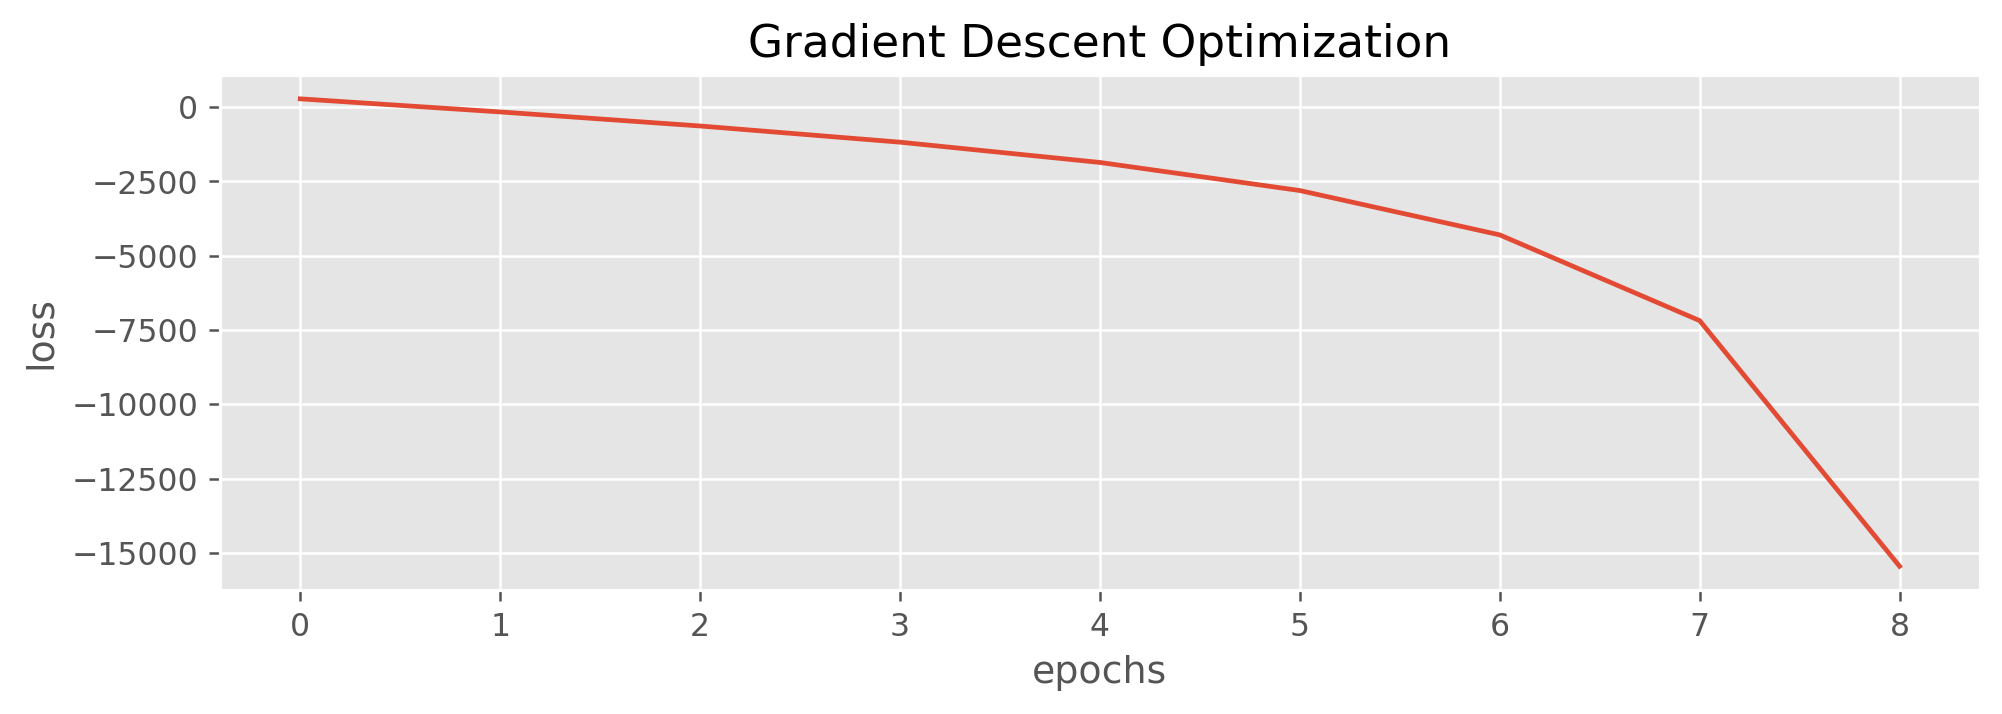

In [257]:
plt.figure(figsize=(10,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(loss_seq)), loss_seq)
plt.title('Gradient Descent Optimization')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

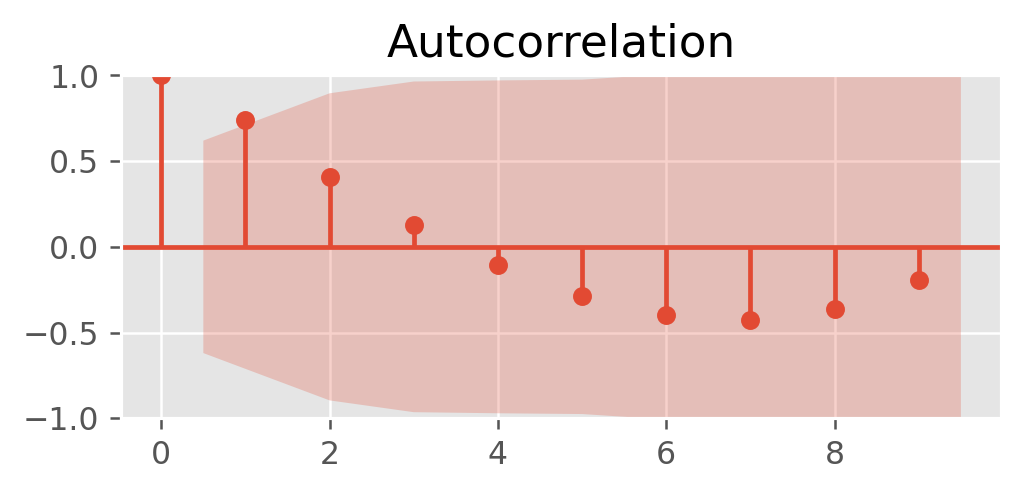

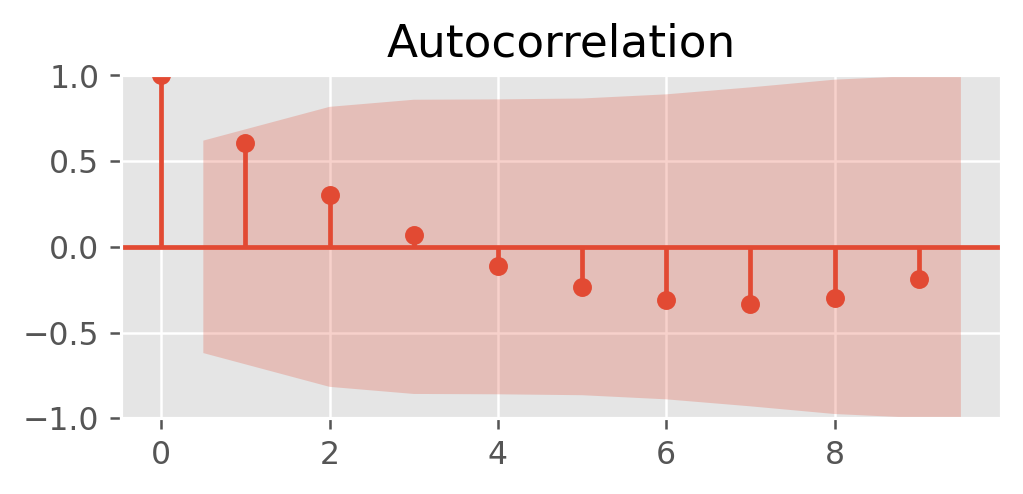

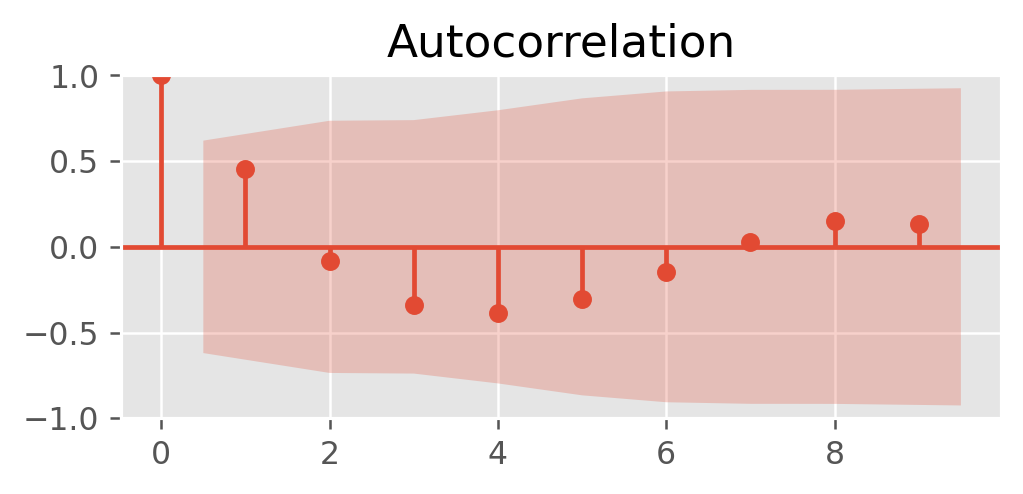

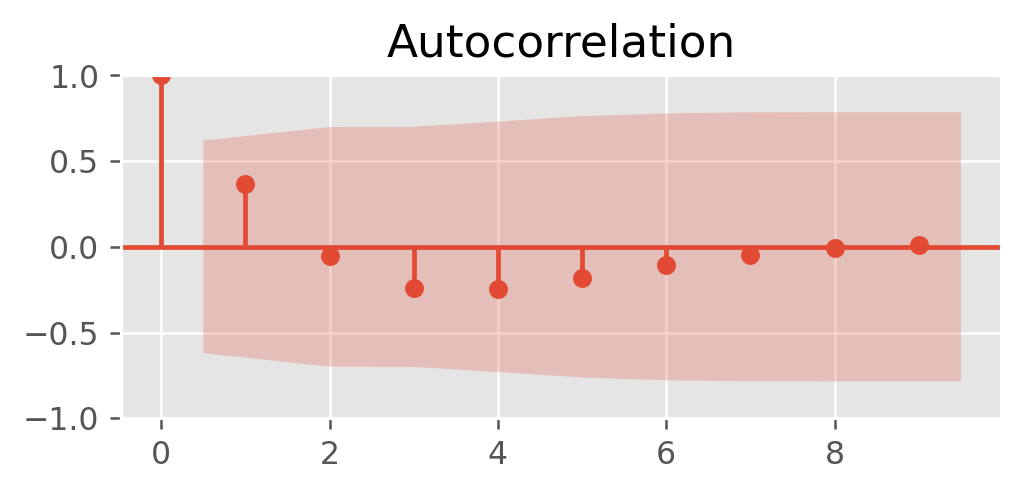

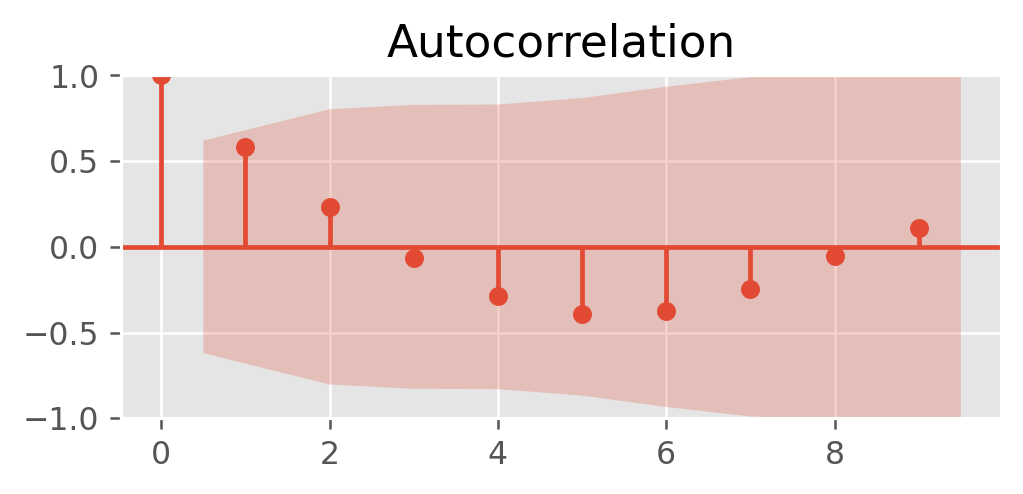

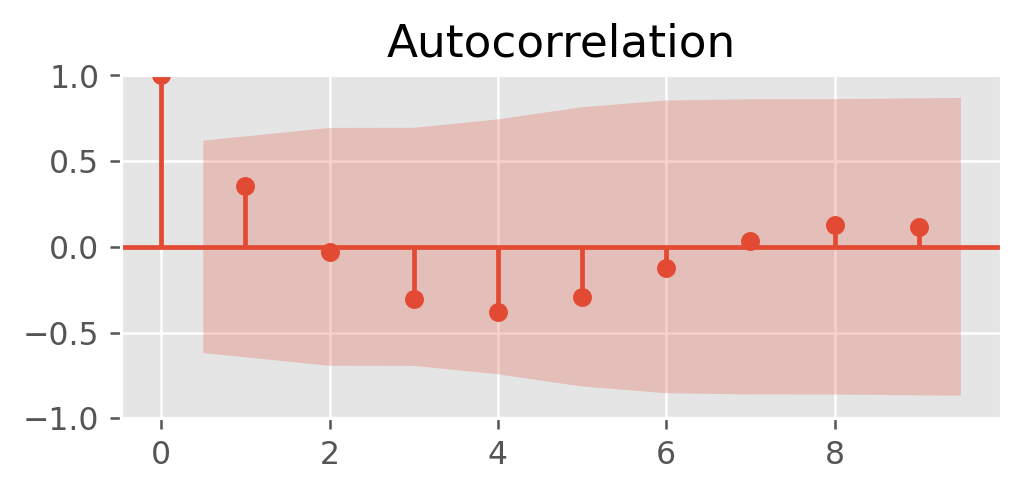

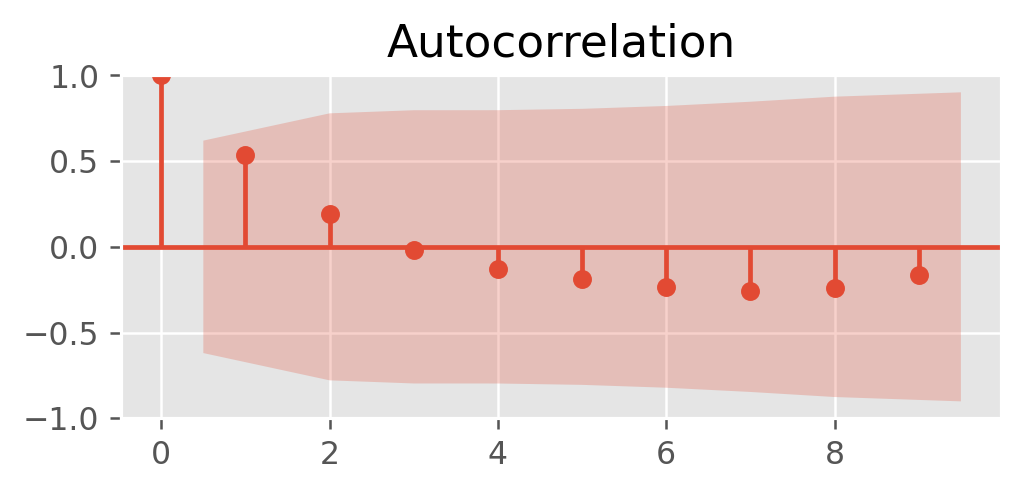

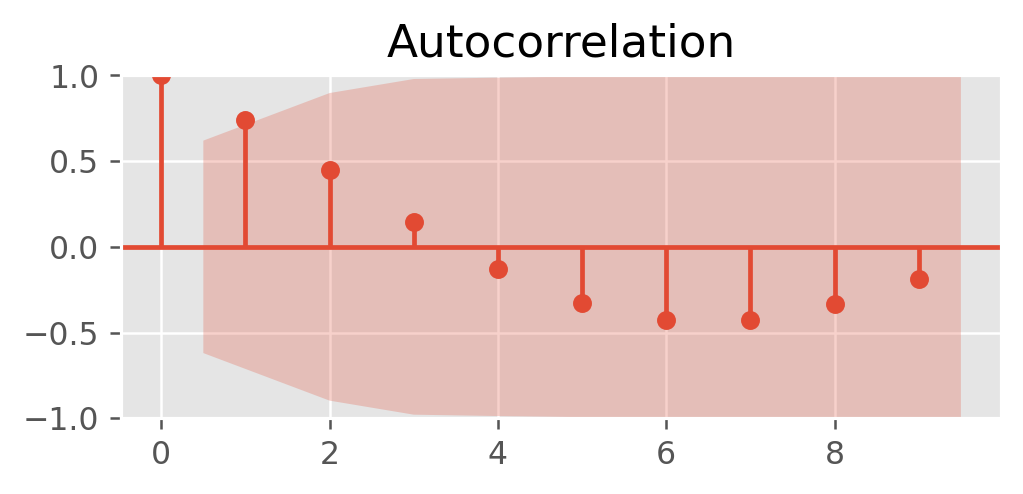

In [258]:
for i in range(grad_seq.shape[1]):
    fig, ax = plt.subplots(figsize=(5, 2))
    sm.graphics.tsa.plot_acf(np.array(grad_seq[:, i]), ax=ax)
    plt.show()